In [1]:
% automatic calculation of mu
% re-initialize x
clear;
close all;

## load data

In [2]:
inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_rectangle_G4215_0852kW.mat';
% inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_halfcross_G4215_0852kW.mat';
% inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_arc1_G4215_0852kW.mat';
% inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_groove1_G4215_0852kW.mat';
load(inputname1,'z_grid_mm','y_grid_mm','k_cond', 'dx', 'N_z','N_y','T_2d_interface','T_inlet_uniform','q_source','IT_conversion_A_div_I_conversion','I_conversion','vertices');

% interface to qbcs
q_source_qbcs = q_source(2:end, :);
q_source_qbcs_flatten = q_source_qbcs(:);
x_true = q_source_qbcs_flatten*-dx/k_cond;

## sensor array generation

In [3]:
%sensor distance 1
% input_z = [2:101]; % input
% input_y = [1:19]; % input
% sensor distance 2
% input_z = [2:2:100]; % input
% input_y = [1:2:19]; % input
% sensor distance 3 (Simulation)
input_z = [2:3:101]; % input
input_y = [1:3:19]; % input
% sensor distance 3 (Experiment)
% input_z = [19:3:84]; % input
% input_y = [11:-3:1]; % input
% sensor distance 4
% input_z = [2:4:98]; % input
% input_y = [1:4:17]; % input
% sensor distance 5
% input_z = [2:5:97]; % input
% input_y = [1:5:16]; % input
% sensor distance 6
% input_z = [2:6:98]; % input
% input_y = [1:6:19]; % input

## assign and produce sensor index

In [4]:
N_x_1 = 300+1; % liquid grid points (including both ends) in x-direction
sensor_user_input = zeros(length(input_z)*length(input_y), 3);
sensor_user_input(:,2) = N_x_1; % at solid-liquid interface
for iz=1:length(input_z)
    for iy=1:length(input_y)
        row = (iz-1)*length(input_y) + iy;
        sensor_user_input(row, 1) = input_z(iz);
        sensor_user_input(row, 3) = input_y(iy);
    end
end

sensor_index_z = sensor_user_input(:,1);
sensor_index_x = sensor_user_input(:,2);
sensor_index_y = sensor_user_input(:,3);
sensor_index_qbcs = (sensor_index_z-1) + (sensor_index_y-1)*(N_z-1); % indexing within qbcs
number_sensor = length(sensor_index_z);

Phi_location_sensor_qbcs = sparse(number_sensor, (N_z-1)*N_y); % sensor at qbcs grid
T_sensing = zeros(number_sensor,1); % [K] column vector for temperature measurements
for ids=1:size(sensor_index_qbcs, 1)
    Phi_location_sensor_qbcs(ids, sensor_index_qbcs(ids)) = 1;
    T_sensing(ids) = T_2d_interface(sensor_index_z(ids), sensor_index_y(ids));
end

## generate artificial noise

In [5]:
rng('default') % rng(1)
noise_magnitude = 0.5; % [Kelvin] INPUT
fprintf('artificial noise magnitude [K]: %.2f \n', noise_magnitude);

artificial noise magnitude [K]: 0.50

In [6]:
T_sensing = T_sensing + noise_magnitude*randn(number_sensor, 1); % add artifical noise


## gradient operator

In [7]:
Dz = zeros((N_z-1)*N_y, (N_z-1)*N_y);
matrix_idr = repmat([2:N_z-1]',1,N_y) + repmat((N_z-1)*(0:N_y-1),N_z-2,1);
column_idr = matrix_idr(:);
column_idc_diag = column_idr;
vector_id_diag = column_idr + N_y*(N_z-1)*(column_idc_diag - 1);
column_idc_offdiag = column_idr-1;
vector_id_offdiag = column_idr + N_y*(N_z-1)*(column_idc_offdiag - 1);
Dz(vector_id_diag) = 1;
Dz(vector_id_offdiag) = -1;

Dy = zeros((N_z-1)*N_y, (N_z-1)*N_y);
column_idr = N_z:N_y*(N_z-1);
column_idc_diag = column_idr;
vector_id_diag = column_idr + N_y*(N_z-1)*(column_idc_diag - 1);
column_idr = N_z:(N_y)*(N_z-1);
column_idc_offdiag = column_idr - (N_z-1);
vector_id_offdiag = column_idr + N_y*(N_z-1)*(column_idc_offdiag - 1);
Dy(vector_id_diag) = 1;
Dy(vector_id_offdiag) = -1;

% difference in z and y direction
Dzy = [Dz; Dy]; % into one operation

## input for IRN iteration

In [8]:
A = full(Phi_location_sensor_qbcs*IT_conversion_A_div_I_conversion);
b = T_sensing - T_inlet_uniform;
L = Dzy;
pnorm = 2; % INPUT
qnorm = 0.1; %  INPUT
n_iter = 50; %  INPUT maximum number of iteration
mu = 0.1; % INPUT initial condition (e.g., 0.1403)
epsilon_F = 10^-3;
epsilon_R = 10^-3;
n_re_initialize = 2;

m = size(A, 1); % number of measurement
n = size(A, 2); % number of unknown

## Initializations

In [9]:
mu0 = mu;
x0 = (A'*A + mu0*L'*L)\(A'*b);
x = x0;
wf = zeros();

residual_x0 = norm(A*x0-b, pnorm)^pnorm;
relative_error_x0 = norm(x0 - x_true)/norm(x_true);
Lqq_x0 = norm(L*x0, qnorm)^qnorm;
cost_function_x0 = 1/pnorm*residual_x0 + mu/qnorm*Lqq_x0;
qbcs_x0 = x0*-k_cond/(1*dx); % adjust unit to recover heat flux [W/m2]
qbcs_2d_x0 = reshape(qbcs_x0, [N_z-1, N_y]); % 2d profile
L0_x0 = nnz(abs(L*qbcs_x0) >= max(L*qbcs_x0)*0.05);

## iteration history to save

In [10]:
x_history = {}; % check the difference betwen {} and []
mu_history = [];
residual_history = [];
relative_error_history =[];
cost_function_history = [];
L0_history = [];
Lqq_history = zeros(1, length(x_history));
convergence_check_history = [];

## IRN iteration

In [11]:
for ii = 1:n_iter

## weighting matrix

In [12]:
    v = A*x - b;
    wf = smoothed_holder_weights(v, epsilon_F, pnorm);
    u = L * x;
    wr = smoothed_holder_weights(u, epsilon_R, qnorm);

## solve normal equation: convex optimization problem

In [13]:
    AW12 = A .* sqrt(wf);     % Step 1: Element-wise multiplication of each row of A by w, newer MATLAB syntax (=W_F*A)
    LW12 = L .* sqrt(wr);
    T = AW12' * AW12 + mu* LW12' * LW12;
    Wb = b .* wf; % Step 1: Element-wise multiplication of b by W
    rhs = A' * Wb; % Step 2: Multiply the result by A^T
    x = T\rhs; % solve normal equation

## save result

In [14]:
    x_history{end+1} = x; % Store current solution
    Lqq_history(ii) = norm(L*x, qnorm)^qnorm;

    x_diff = x - x_true;
    residual_history(end + 1) = norm(A*x-b, pnorm)^pnorm;
    cost_function_history(end + 1) = 1/pnorm*residual_history(end) + mu/qnorm*Lqq_history(ii);
    relative_error_history(end + 1) = norm(x_diff)/norm(x_true);

    qbcs_x = x*-k_cond/(1*dx); % recover heat source flux [W/m2]
    gradient_check_zy = L*qbcs_x;
    L0_history(end + 1) = nnz(abs(gradient_check_zy) >= max(gradient_check_zy)*0.05);

    mu_history(end+1) = mu;

## next iteration

In [15]:
    mu = n*qnorm/Lqq_history(ii);

    if ii>1
        convergence_check_history(ii) = norm(x_history{end}-x_history{end-1})/norm(x_history{end});
        if convergence_check_history(ii) <= 10^-5
        fprintf('iteration %d (over %d), x converged. μ = (%.2e)\n', ii, n_iter, mu);
        break;
        end
    end

    % re-initialize x for guarantee convergence with any mu0
    if ii == n_re_initialize
        fprintf('iteration %d, re-initialize x', ii);
        x = (A'*A + mu*L'*L)\(A'*b);
    end

end

iteration 2, re-initialize x
iteration 25 (over 50), x converged. μ = (1.43e-01)

## heat flux reconstruction

In [16]:
iteration_plot = ii; % INPUT iteration index for plot
fprintf('pnorm=%.1d, qnorm=%.1d, μ=%.2e (μ0 = %.2e), iter=%d (%d)\n', pnorm, qnorm, mu, mu0, iteration_plot, n_iter);

pnorm=2, qnorm=1.0e-01, μ=1.43e-01 (μ0 = 1.00e-01), iter=25 (50)

In [17]:

x = x_history{iteration_plot};
qbcs_x = x*-k_cond/(1*dx); % recover heat source flux [W/m2]
qbcs_2d_x = reshape(qbcs_x, [N_z-1, N_y]); % reshape

## check edge

In [18]:
solultion_edge_z_2d = reshape(Dz*q_source_qbcs_flatten, [N_z-1, N_y]);
solution_edge_y_2d = reshape(Dy*q_source_qbcs_flatten, [N_z-1, N_y]);
solution_edge_zy_2d = (solultion_edge_z_2d.^2 + solution_edge_y_2d.^2).^(1/2);
reconst_edge_z_2d = reshape(Dz*qbcs_x, [N_z-1, N_y]);
reconst_edge_y_2d = reshape(Dy*qbcs_x, [N_z-1, N_y]);
reconst_edge_zy_2d = (reconst_edge_z_2d.^2 + reconst_edge_y_2d.^2).^(1/2);

## comparison component

In [19]:
solution_L2 = norm(Phi_location_sensor_qbcs*IT_conversion_A_div_I_conversion*x_true + T_inlet_uniform - T_sensing);
solution_L1 = norm(L*x_true, 1);
solution_Lqq = norm(L*x_true, qnorm)^qnorm;
fprintf('L2 (sol) = %.3e, L1 (sol) = %.3e, Lq^q (sol) = %.3e\n', solution_L2, solution_L1, solution_Lqq);

L2 (sol) = 8.193e+00, L1 (sol) = 3.749e+01, Lq^q (sol) = 5.293e+01

In [20]:

reconst_L2 = norm(Phi_location_sensor_qbcs*IT_conversion_A_div_I_conversion*x + T_inlet_uniform - T_sensing);
reconst_L1 = norm(L*x, 1);
reconst_Lqq = norm(L*x, qnorm)^qnorm;
fprintf('L2 (rec) = %.3e, L1 (rec) = %.3e, Lq^q (rec) = %.3e\n', reconst_L2, reconst_L1, reconst_Lqq);

L2 (rec) = 7.494e+00, L1 (rec) = 3.952e+01, Lq^q (rec) = 1.331e+03

## nonzero elements

In [21]:
L0_x_true = nnz(abs(L*x_true) >= max(L*x_true)*0.05);
fprintf('nnz (sol) = %.3e , nnz (rec) = %.3e\n', L0_x_true, L0_history(iteration_plot));

nnz (sol) = 5.500e+01 , nnz (rec) = 6.800e+01

## check overlapping area

In [22]:
true_source = q_source_qbcs_flatten > 0; % Convert to binary (non-zero elements are set to 1)
recon_source = qbcs_x > max(qbcs_x)*0.05; % Convert to binary (non-zero elements are set to 1)
intersection = true_source & recon_source; % Calculate the Intersection (logical AND operation)
union = true_source | recon_source; % Calculate the Union (logical OR operation)
area_of_intersection = sum(intersection(:)); % Calculate the area of intersection and area of union
area_of_union = sum(union(:));
iou = area_of_intersection / area_of_union; % Compute the Intersection over Union (IoU)
fprintf('The Intersection over Union (IoU) is: %.3f\n', iou); % Display the IoU result

The Intersection over Union (IoU) is: 0.997

## estimation of noise

In [23]:
noise_estimation = sqrt(residual_history(end)/number_sensor);
fprintf('Estimated noise magnitude [K]: %.2f\n', noise_estimation); %

Estimated noise magnitude [K]: 0.49

## initial condition


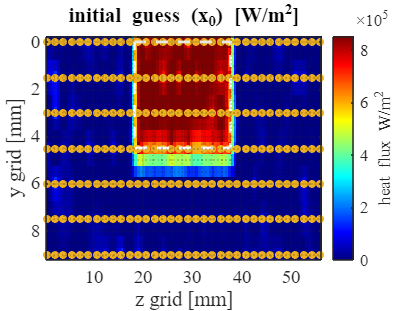

In [24]:
figure;
set(gcf, 'WindowState', 'maximized');
% subplot(2,1,1)
imagesc(z_grid_mm(2:end), y_grid_mm, qbcs_2d_x0')
hold on
scatter(z_grid_mm(sensor_index_z), y_grid_mm(sensor_index_y),'filled','displayname','sensor locations','MarkerFaceColor','#EDB120')
hold on
plot(vertices(:,1)*1000, vertices(:,2)*1000, 'w--', 'LineWidth', 2,'handlevisibility','off'); % draw white line (need existing figure)
colormap('jet');
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
cmax = max(max(q_source_qbcs));
caxis([0 cmax])
xlabel('z grid [mm]')
ylabel('y grid [mm]')
% titleStr = sprintf('heat source (solution) (L_2 = %.3e, L_1 = %.3e, L_q^q = %.3e)', ...
%                    solution_L2, solution_L1, solution_Lqq);
titleStr = sprintf('initial guess (x_0) [W/m^2]');
title(titleStr);
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


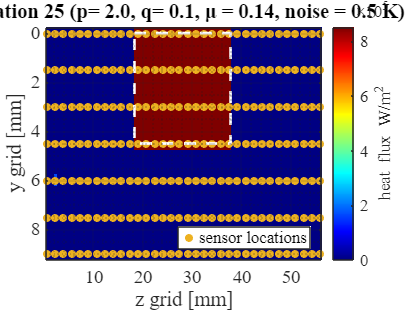

In [25]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, qbcs_2d_x')
hold on
scatter(z_grid_mm(sensor_index_z), y_grid_mm(sensor_index_y),'filled','displayname','sensor locations','MarkerFaceColor','#EDB120')
hold on
plot(vertices(:,1)*1000, vertices(:,2)*1000, 'w--', 'LineWidth', 2,'handlevisibility','off'); % draw white line (need existing figure)
colormap('jet');
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
caxis([0 cmax])
xlabel('z grid [mm]')
ylabel('y grid [mm]')
% titleStr = sprintf('[sim] IRN heat source id (p_{norm}= %.1f, q_{norm}= %.1f, mu = %.1e, iter = %d, noise = %.1e) (L_2 = %.3e, L_1 = %.3e, L_q^q = %.3e)', ...
%                    pnorm, qnorm, mu, iteration_plot, noise_magnitude, reconst_L2, reconst_L1, reconst_Lqq);
titleStr = sprintf('iteration %d (p= %.1f, q= %.1f, μ = %.2f, noise = %.1f K)', iteration_plot, pnorm, qnorm, mu, noise_magnitude);
title(titleStr);
legend('show','location','southeast')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor

In [26]:

% original solution
% imagesc(z_grid_mm(2:end), y_grid_mm, q_source(2:end,:)')
% hold on
% scatter(z_grid_mm(sensor_index_z), y_grid_mm(sensor_index_y),'filled','displayname','sensor locations','MarkerFaceColor','#EDB120')
% hold on
% plot(vertices(:,1)*1000, vertices(:,2)*1000, 'w--', 'LineWidth', 2,'handlevisibility','off'); % draw white line (need existing figure)
% colormap('jet');
% c = colorbar; % Get the handle of the colorbar
% ylabel(c, 'heat flux W/m^2')
% caxis([0 cmax])
% xlabel('z grid [mm]')
% ylabel('y grid [mm]')
% % titleStr = sprintf('heat source (solution) (L_2 = %.3e, L_1 = %.3e, L_q^q = %.3e)', ...
% %                    solution_L2, solution_L1, solution_Lqq);
% titleStr = sprintf('original solution');
% title(titleStr);
% set(gca,'FontSize',24,'fontname','times')
% grid on
% grid minor

## visualize the convergence history


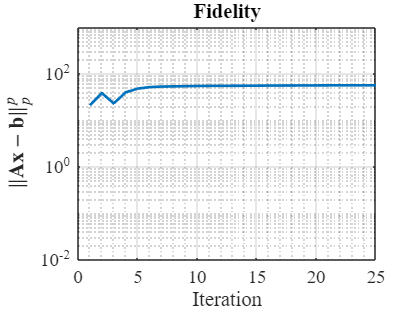

In [27]:
figure;
set(gcf, 'WindowState', 'maximized');
% subplot(1,6,1)
semilogy(residual_history,'-', 'LineWidth', 2, 'color','#0072BD');
hold on
plot(0, residual_x0,'o','LineWidth', 3,'color','#0072BD','handlevisibility','off')
xlabel('Iteration');
ylabel(' $\|\mathbf{A}\mathbf{x}-\mathbf{b}\|_p^p$ ', 'Interpreter', 'latex', 'FontSize', 18);
title('Fidelity');
set(gca,'FontSize',14,'fontname','times')
ylim([10^-2 10^3])
grid on;
grid minor;


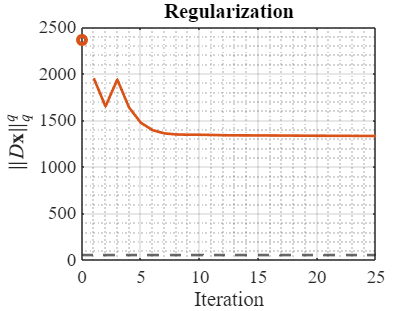

In [28]:

figure;
set(gcf, 'WindowState', 'maximized');
plot(Lqq_history,'-', 'LineWidth', 2, 'color','#D95319');
hold on
plot(0, Lqq_x0,'o','LineWidth', 3,'color','#D95319','handlevisibility','off')
hold on
yline(solution_Lqq, '--','LineWidth', 2,'displayname','solution')
xlabel('Iteration');
ylabel(' $\|D\mathbf{x}\|_q^q$ ', 'Interpreter', 'latex', 'FontSize', 18);
title('Regularization');
set(gca,'FontSize',14,'fontname','times')
ylim([0 2500])
grid on;
grid minor;


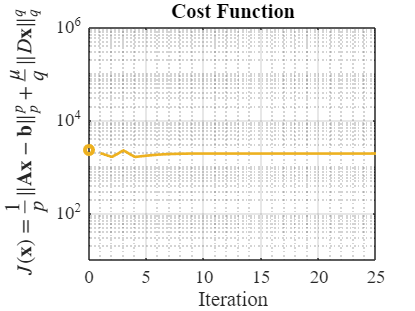

In [29]:

figure;
set(gcf, 'WindowState', 'maximized');
semilogy(cost_function_history,'-', 'LineWidth', 2, 'Color', '#EDB120');
hold on
plot(0, cost_function_x0,'o','LineWidth', 3,'color','#EDB120','handlevisibility','off')
xlabel('Iteration');
ylabel(' $J(\mathbf{x})=\frac{1}{p}\|\mathbf{A}\mathbf{x} -\mathbf{b}\|_p^p + \frac{\mu}{q}\|D\mathbf{x}\|_q^q$ ', 'Interpreter', 'latex', 'FontSize', 18);
title('Cost Function');
set(gca, 'FontSize', 14, 'FontName', 'Times');
ylim([10 10^6])
grid on;
grid minor;


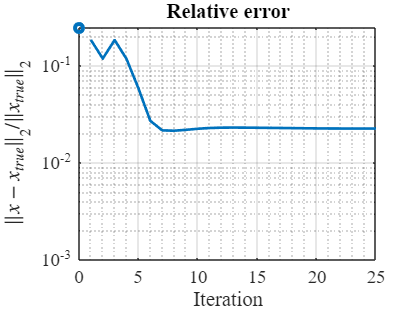

In [30]:

figure;
set(gcf, 'WindowState', 'maximized');
semilogy(relative_error_history, '-','LineWidth', 2, 'color','#0072BD');
hold on
plot(0, relative_error_x0,'o','LineWidth', 3,'color','#0072BD','handlevisibility','off')
xlabel('Iteration');
ylabel(' $ {\left\|x-x_{true} \right\|_2} / {\left\| x_{true} \right\|_2}$ ', 'Interpreter', 'latex', 'FontSize', 18);
title('Relative error');
set(gca,'FontSize',14,'fontname','times')
ylim([10^-3 0.25])
grid on;
grid minor;


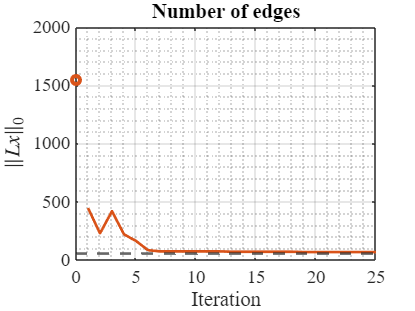

In [31]:

figure;
set(gcf, 'WindowState', 'maximized');
plot(L0_history,'-','LineWidth', 2, 'color','#D95319');
hold on
plot(0, L0_x0,'o','LineWidth', 3,'color','#D95319','handlevisibility','off')
hold on
yline(L0_x_true,'--','LineWidth',2,'displayname','solution')
xlabel('Iteration');
ylabel(' $\|Lx\|_0$ ', 'Interpreter', 'latex', 'FontSize', 18);
title('Number of edges');
set(gca,'FontSize',14,'fontname','times')
ylim([0 2000])
grid on;
grid minor;


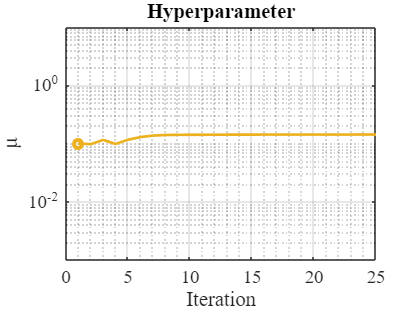

In [32]:

figure;
set(gcf, 'WindowState', 'maximized');
semilogy(mu_history,'-','LineWidth', 2, 'color','#EDB120')
hold on
plot(1, mu0,'o','LineWidth', 3,'color','#EDB120','handlevisibility','off')
xlabel('Iteration');
ylabel('μ', 'FontSize', 18);
title('Hyperparameter');
set(gca,'FontSize',14,'fontname','times')
ylim([10^-3 10])
grid on;
grid minor;

## gradient


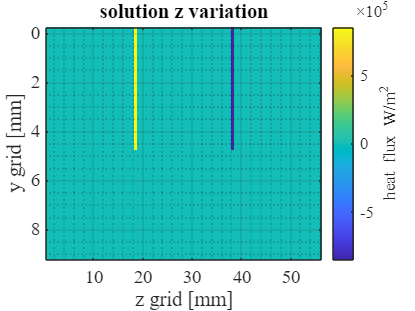

In [33]:
figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, solultion_edge_z_2d')
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('solution z variation')
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


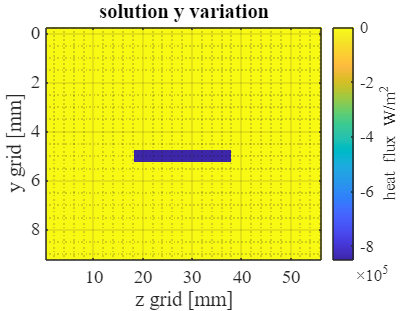

In [34]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, solution_edge_y_2d')
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('solution y variation')
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


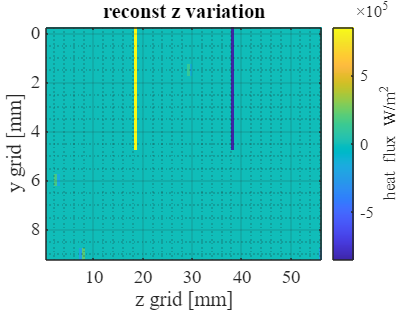

In [35]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, reconst_edge_z_2d')
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('reconst z variation')
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


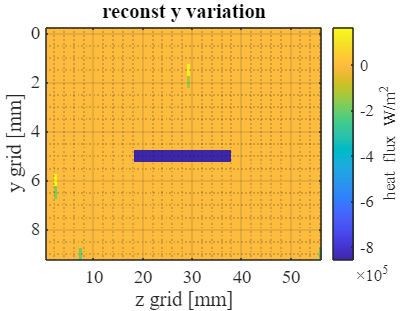

In [36]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, reconst_edge_y_2d')
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('reconst y variation')
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


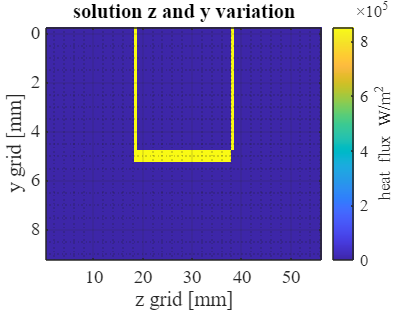

In [37]:
figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, solution_edge_zy_2d')
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('solution z and y variation')
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor


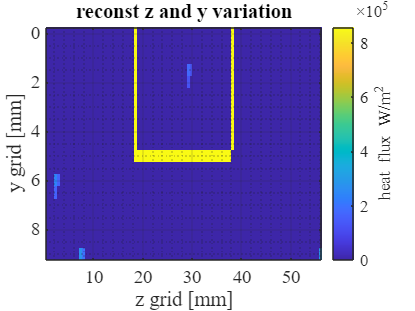

In [38]:

figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, reconst_edge_zy_2d')
xlabel('z grid [mm]')
ylabel('y grid [mm]')
title('reconst z and y variation')
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux W/m^2')
set(gca,'FontSize',14,'fontname','times')
grid on
grid minor